# Bot de inversion para cripto

In [1]:
#!pip install yfinance
#!pip install mpl_finance
#!pip install python-binance
#!pip3 install plotly

## import dependencies

In [45]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from datetime import date
from datetime import timedelta
import plotly.graph_objects as go
from binance import Client
from config import API_Key,Secret_Key
import os

## Gathering data with binance api

In [3]:
client = Client(API_Key, Secret_Key)

In [4]:
# get historical kline data from any date range
#BTCOIN USDOLAR PRICE
#first currency and crypto,then time interval, and time to go back
# arguments of function have to be strings


def get_crypto_data(crypto, interval, lookback):
    Crypto_df = pd.DataFrame(client.get_historical_klines(crypto, interval, lookback + ' ago UTC'))
    
   # show only first 5 columns
    Crypto_df = Crypto_df.iloc[:,:6]
    #naming columns
    Crypto_df.columns = ['Date_and_Time','Open', 'High', 'Low','Last','Volume']
    # from the complete data, set index to date
#     Crypto_df = Crypto_df.\
#     set_index(pd.DatetimeIndex(Crypto_df['Date'].values))
#     Crypto_df.tail()
    Crypto_df = Crypto_df.set_index('Date_and_Time')
    Crypto_df.index = pd.to_datetime(Crypto_df.index, unit='ms')
#     Crypto_df.tz_localize('UTC').tz_convert('Mexico/General')
    

   # all values are stored as string so change them into float.
    Crypto_df = Crypto_df.astype(float)
    return Crypto_df

## Creating crypto df

In [5]:
lookback = '6 months'
crypto_df= get_crypto_data('BTCUSDT', '30m', lookback).tz_localize('UTC').tz_convert('Mexico/General')
crypto_df.shape

(8819, 5)

In [6]:
crypto_df.tail(10)

,Open,High,Low,Last,Volume
Date_and_Time,,,,,
2021-11-21 17:00:00-06:00,59110.33,59262.61,59000.00,59169.77,526.11441
2021-11-21 17:30:00-06:00,59169.77,59213.29,58500.00,58622.02,1195.04714
2021-11-21 18:00:00-06:00,58617.70,58757.14,57963.03,58238.92,2220.46370
2021-11-21 18:30:00-06:00,58239.00,58336.10,58048.92,58118.54,891.54405
2021-11-21 19:00:00-06:00,58118.54,58244.99,57600.00,58008.80,1319.05602
2021-11-21 19:30:00-06:00,58008.79,58180.09,57914.93,58032.61,750.19320
2021-11-21 20:00:00-06:00,58032.60,58108.90,57320.00,57442.78,1370.57063
2021-11-21 20:30:00-06:00,57442.79,57813.17,57305.00,57683.97,929.58400
2021-11-21 21:00:00-06:00,57683.97,57803.23,57578.81,57590.16,595.58884


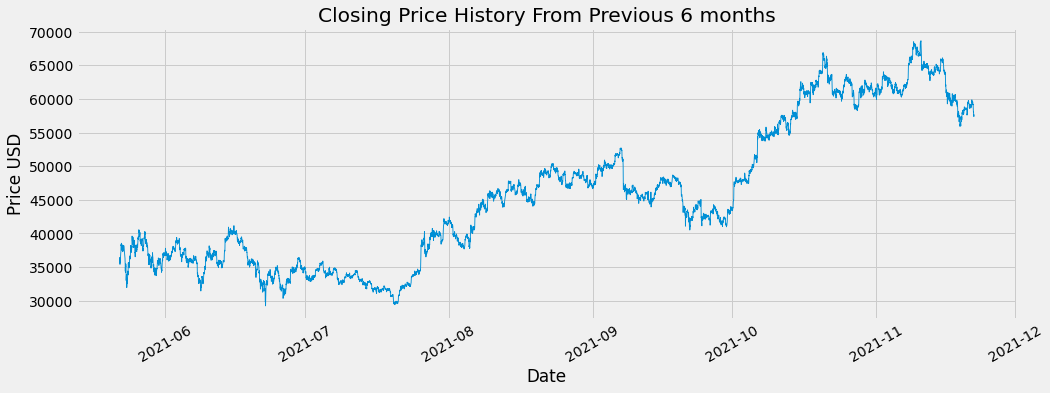

In [7]:
# plot prices
plt.figure(figsize=(15, 5))
plt.plot(crypto_df['Last'],label='closing price', linewidth = 0.9)
plt.title(f'Closing Price History From Previous {lookback}')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.xticks(rotation=30)
plt.show()

In [8]:
# fig = go.Figure(data=[go.Candlestick(x=crypto_df.index,
#                 open=crypto_df['Open'],
#                 high=crypto_df['High'],
#                 low=crypto_df['Low'],
#                 close=crypto_df['Last'])])
# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

## code machine larning: Linear regresion and tecnical indicators

In [9]:
# showing only BTC price
crypto_last_price_df = crypto_df[['Last']]
crypto_last_price_df.head(16)

,Last
Date_and_Time,
2021-05-21 23:00:00-05:00,36459.78
2021-05-21 23:30:00-05:00,36304.18
2021-05-22 00:00:00-05:00,35411.78
2021-05-22 00:30:00-05:00,36376.25
2021-05-22 01:00:00-05:00,35675.53
2021-05-22 01:30:00-05:00,36412.47
2021-05-22 02:00:00-05:00,36126.75
2021-05-22 02:30:00-05:00,36269.28
2021-05-22 03:00:00-05:00,36592.73


In [10]:
#  variable for predicting x number of periods into the future
predict_periods = 16 #numer of periods, then change this info to function

# create another column shifted n units up
crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)

<ipython-input-10-91f82b2f9c00>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)


In [11]:
# show df with new column
crypto_last_price_df.head(16)

,Last,Prediction
Date_and_Time,,
2021-05-21 23:00:00-05:00,36459.78,38478.08
2021-05-21 23:30:00-05:00,36304.18,38151.81
2021-05-22 00:00:00-05:00,35411.78,38543.20
2021-05-22 00:30:00-05:00,36376.25,38310.57
2021-05-22 01:00:00-05:00,35675.53,38365.27
2021-05-22 01:30:00-05:00,36412.47,37808.48
2021-05-22 02:00:00-05:00,36126.75,37501.90
2021-05-22 02:30:00-05:00,36269.28,38162.40
2021-05-22 03:00:00-05:00,36592.73,38282.62


In [12]:
# show last 15 rows of new dataset
crypto_last_price_df.tail(17)

,Last,Prediction
Date_and_Time,,
2021-11-21 13:30:00-06:00,59314.13,57320.93
2021-11-21 14:00:00-06:00,59432.30,NaN
2021-11-21 14:30:00-06:00,59585.00,NaN
2021-11-21 15:00:00-06:00,59542.16,NaN
2021-11-21 15:30:00-06:00,59472.09,NaN
2021-11-21 16:00:00-06:00,59319.11,NaN
2021-11-21 16:30:00-06:00,59110.33,NaN
2021-11-21 17:00:00-06:00,59169.77,NaN
2021-11-21 17:30:00-06:00,58622.02,NaN


In [13]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(crypto_last_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_periods]
print(a)

[[36459.78]
 [36304.18]
 [35411.78]
 ...
 [59436.01]
 [59341.01]
 [59314.13]]


In [14]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = crypto_last_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_periods]
print(b)

[38478.08 38151.81 38543.2  ... 57683.97 57590.16 57320.93]


In [15]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [16]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

In [17]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: 0.8395294457267435


In [18]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(crypto_last_price_df[['Last']])[-predict_periods:]
print(a_projection)

[[59432.3 ]
 [59585.  ]
 [59542.16]
 [59472.09]
 [59319.11]
 [59110.33]
 [59169.77]
 [58622.02]
 [58238.92]
 [58118.54]
 [58008.8 ]
 [58032.61]
 [57442.78]
 [57683.97]
 [57590.16]
 [57320.93]]


In [19]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[59474.67951955 59627.25640876 59584.4509475  59514.4374398
 59361.58077633 59152.96910031 59212.3611782  58665.05278879
 58282.26165418 58161.97870773 58052.32718303 58076.11798677
 57486.76352337 57727.75906959 57634.02470171 57365.01176208]


In [20]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual_price', 'predicted_price'])

previously_predicted = results_df[['predicted_price']]

date = datetime.now().strftime("%Y_%m_%d_%I_%M_%S_%p")
previously_predicted.to_csv(f'Resources/previous_predicted_price_{date}.csv') 

pwd = os.getcwd()
path = os.path.join(pwd,'Resources')
entries = os.listdir(path)

price_results_df = pd.concat([results_df, pd.read_csv('Resources/'+ entries[-2])], axis =1)
price_results_df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
price_results_df.columns = ['actual_price', 'predicted_price', 
                                            'previously_predicted_price']
price_results_df.head(17)

,actual_price,predicted_price,previously_predicted_price
0,[59432.3],59474.679520,57888.276128
1,[59585.0],59627.256409,57888.411838
2,[59542.16],59584.450948,57932.466583
3,[59472.09],59514.437440,57921.482583
4,[59319.11],59361.580776,57907.648681
5,[59110.33],59152.969100,57901.143099
6,[59169.77],59212.361178,57923.026281
7,[58622.02],58665.052789,57964.612807
8,[58238.92],58282.261654,57962.950363
9,[58118.54],58161.978708,57945.359000


In [21]:
results_df.describe()

,predicted_price
count,16.000000
mean,58586.189547
std,825.155667
min,57365.011762
25%,57971.185155
50%,58473.657221
75%,59389.855462
max,59627.256409


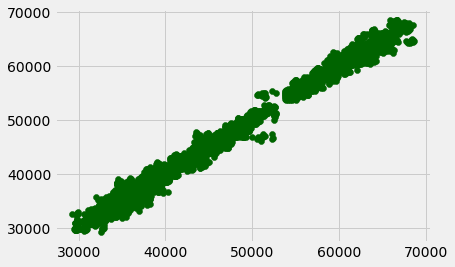

In [22]:
plt.scatter(a, b, color="DarkGreen" )

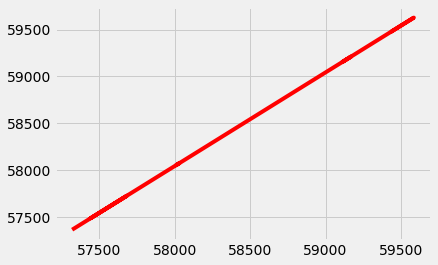

In [23]:
plt.plot(a_projection,Lreg_predict, color='r')

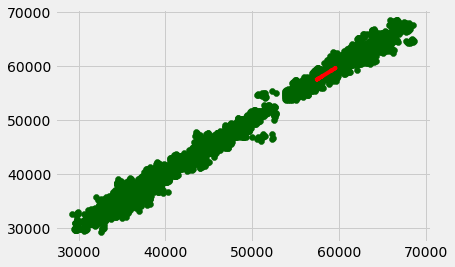

In [24]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## TI MACHINE L GRAPAHS

In [25]:
def TI_MachLearn_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.predicted_price.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.predicted_price.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k')
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r')
    plt.title('MACD graph next 16 periods')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')

   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 2 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['predicted_price'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['predicted_price'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['predicted_price','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['predicted_price'], color = 'k', label='closing price')
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA')
    ax.set_title('BBands next 16 periods')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()    

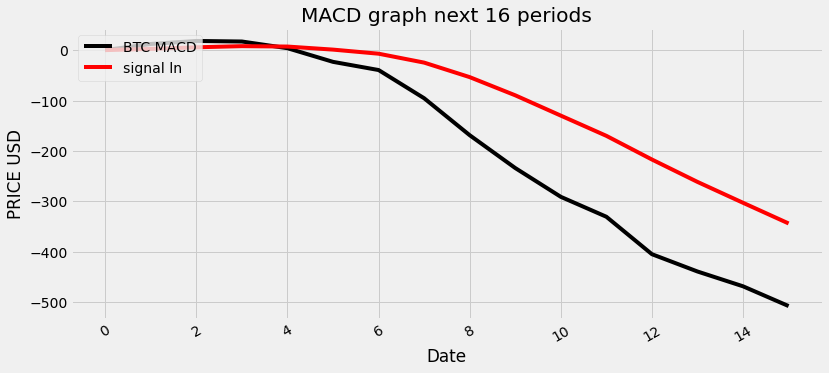

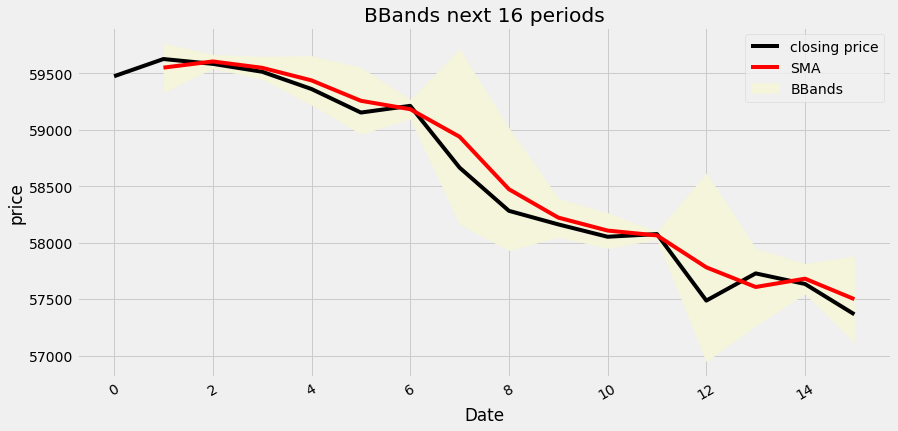

In [26]:
TI_MachLearn_graphs(results_df)

## macd machine learning notification

In [27]:
#buy sell signal
def alert_MACD_ML(signal):
    buy = []
    crypto_buy_price = []
    crypto_sell_price = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            crypto_sell_price.append(np.nan)
            if flag != 1:
                buy.append('1')
                crypto_buy_price.append(signal['predicted_price'][i])
                flag = 1
            else:
                buy.append(np.nan)
                crypto_buy_price.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            crypto_buy_price.append(np.nan)
            if flag != 0:
                sell.append('1')
                crypto_sell_price.append(signal['predicted_price'][i])
                flag = 0
            else:
                sell.append(np.nan)
                crypto_sell_price.append(np.nan)
        else:
            buy.append(np.nan)
            crypto_buy_price.append(np.nan)
            sell.append(np.nan)
            crypto_sell_price.append(np.nan)
    return(buy, sell, crypto_buy_price, crypto_sell_price)
            

In [28]:
#Create DF for MACD
crypto_MACD_ML_df= results_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['S_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['L_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_ML_df['MACD_line']=\
                          crypto_MACD_ML_df.S_EMA-crypto_MACD_ML_df.L_EMA
#calculate Signal Line
crypto_MACD_ML_df['Sig_line']=\
                          crypto_MACD_ML_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_ML_df.tail(20)

,actual_price,predicted_price,S_EMA,L_EMA,MACD_line,Sig_line
0,[59432.3],59474.679520,59474.679520,59474.679520,0.000000,0.000000
1,[59585.0],59627.256409,59498.152887,59485.981511,12.171376,2.434275
2,[59542.16],59584.450948,59511.429512,59493.275544,18.153968,5.578214
3,[59472.09],59514.437440,59511.892270,59494.843092,17.049178,7.872407
4,[59319.11],59361.580776,59488.767425,59484.971809,3.795616,7.057049
5,[59110.33],59152.969100,59437.106144,59460.379016,-23.272872,0.991065
6,[59169.77],59212.361178,59402.529995,59442.007324,-39.477329,-7.102614
7,[58622.02],58665.052789,59289.071964,59384.455136,-95.383173,-24.758726
8,[58238.92],58282.261654,59134.178070,59302.811175,-168.633105,-53.533602
9,[58118.54],58161.978708,58984.608937,59218.305066,-233.696129,-89.566107


In [29]:
#create buy and sell columns in df
x = alert_MACD_ML(crypto_MACD_ML_df)
crypto_MACD_ML_df['Buy_Notification'] = x[0]
crypto_MACD_ML_df['Sell_Notification'] = x[1]
crypto_MACD_ML_df['Crypto_buy_price'] = x[2]
crypto_MACD_ML_df['Crypto_sell_price'] = x[3]

# create df with buy and sell info
crypto_MACD_ML_BuySell_Sig_df = crypto_MACD_ML_df[['Buy_Notification', 'Sell_Notification',
                                                   'Crypto_buy_price','Crypto_sell_price' ]]
crypto_MACD_ML_BuySell_Sig_df.fillna(0).head(50)

,Buy_Notification,Sell_Notification,Crypto_buy_price,Crypto_sell_price
0,0,0,0.000000,0.000000
1,1,0,59627.256409,0.000000
2,0,0,0.000000,0.000000
3,0,0,0.000000,0.000000
4,0,1,0.000000,59361.580776
5,0,0,0.000000,0.000000
6,0,0,0.000000,0.000000
7,0,0,0.000000,0.000000
8,0,0,0.000000,0.000000
9,0,0,0.000000,0.000000


## MACD df

In [30]:
#Create DF for MACD
crypto_MACD_df= crypto_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_df['MACD_line']=\
                          crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
#calculate Signal Line
crypto_MACD_df['Sig_line']=\
                          crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_df.tail(20)


,Open,High,Low,Last,Volume,S_EMA,L_EMA,MACD_line,Sig_line
Date_and_Time,,,,,,,,,
2021-11-21 12:00:00-06:00,59469.59,59543.92,59270.00,59430.45,866.03100,59282.777974,59132.527671,150.250302,80.339288
2021-11-21 12:30:00-06:00,59430.44,59537.85,59371.83,59436.01,428.11642,59306.352131,59155.007844,151.344288,94.540288
2021-11-21 13:00:00-06:00,59436.02,59576.93,59212.50,59341.01,572.48997,59311.684111,59168.785781,142.898330,104.211896
2021-11-21 13:30:00-06:00,59341.01,59468.82,59230.07,59314.13,493.92140,59312.060402,59179.552020,132.508382,109.871193
2021-11-21 14:00:00-06:00,59314.12,59437.72,59256.99,59432.30,485.35659,59330.558802,59198.274092,132.284709,114.353896
2021-11-21 14:30:00-06:00,59432.29,59696.69,59353.01,59585.00,539.94011,59369.703601,59226.920456,142.783145,120.039746
2021-11-21 15:00:00-06:00,59587.98,59652.93,59347.63,59542.16,475.66361,59396.235355,59250.271533,145.963822,125.224561
2021-11-21 15:30:00-06:00,59542.16,59599.99,59376.14,59472.09,385.22154,59407.905300,59266.702531,141.202770,128.420203
2021-11-21 16:00:00-06:00,59472.10,59515.04,59291.61,59319.11,476.94711,59394.244485,59270.584566,123.659919,127.468146


## MACD buy and sell notification

In [31]:
#buy sell signal
def alert_MACD(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [32]:
#create buy and sell columns in df
x = alert_MACD(crypto_MACD_df)
crypto_MACD_df['Buy_Notification'] = x[0]
crypto_MACD_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_BuySell_Sig_df = crypto_MACD_df[['Buy_Notification', 'Sell_Notification']]
crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(50)

,Buy_Notification,Sell_Notification
Date_and_Time,,
2021-11-21 21:30:00-06:00,0,0
2021-11-21 21:00:00-06:00,0,0
2021-11-21 20:30:00-06:00,0,0
2021-11-21 20:00:00-06:00,0,0
2021-11-21 19:30:00-06:00,0,0
2021-11-21 19:00:00-06:00,0,0
2021-11-21 18:30:00-06:00,0,0
2021-11-21 18:00:00-06:00,0,0
2021-11-21 17:30:00-06:00,0,0


## BOLLINGER BANDS df

In [33]:
crypto_BBand_df =crypto_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
#calculate std
crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
#calculate BB UP
crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
#calculate BB LOW
crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

crypto_BBand_df.head(30)

,Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
Date_and_Time,,,,,,,,,
2021-05-21 23:00:00-05:00,36947.31,37219.45,36366.10,36459.78,3111.249132,NaN,NaN,NaN,NaN
2021-05-21 23:30:00-05:00,36459.78,36635.77,35875.11,36304.18,4215.269873,NaN,NaN,NaN,NaN
2021-05-22 00:00:00-05:00,36304.19,36450.00,35325.20,35411.78,3803.788490,NaN,NaN,NaN,NaN
2021-05-22 00:30:00-05:00,35411.78,36713.09,35200.62,36376.25,3707.799258,NaN,NaN,NaN,NaN
2021-05-22 01:00:00-05:00,36376.26,36510.23,35500.00,35675.53,2552.391300,NaN,NaN,NaN,NaN
2021-05-22 01:30:00-05:00,35675.53,36494.00,35572.97,36412.47,2643.749982,NaN,NaN,NaN,NaN
2021-05-22 02:00:00-05:00,36412.47,36422.39,35596.10,36126.75,3100.167960,NaN,NaN,NaN,NaN
2021-05-22 02:30:00-05:00,36126.75,36496.13,35799.00,36269.28,2521.266560,NaN,NaN,NaN,NaN
2021-05-22 03:00:00-05:00,36266.36,36814.19,36258.96,36592.73,3439.564877,NaN,NaN,NaN,NaN


## BBand buy sell Notification

In [34]:
#buy sell signal
def alert_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['Last'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['Last'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [35]:
#create buy and sell columns in df
x=alert_BBands(crypto_BBand_df)
crypto_BBand_df['Buy_Notification'] = x[0]
crypto_BBand_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_BBand_BuySell_Sig_df = crypto_BBand_df[['Buy_Notification', 'Sell_Notification']]
crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(50)

,Buy_Notification,Sell_Notification
Date_and_Time,,
2021-11-21 21:30:00-06:00,0,0
2021-11-21 21:00:00-06:00,0,0
2021-11-21 20:30:00-06:00,0,0
2021-11-21 20:00:00-06:00,0,0
2021-11-21 19:30:00-06:00,0,0
2021-11-21 19:00:00-06:00,0,0
2021-11-21 18:30:00-06:00,0,0
2021-11-21 18:00:00-06:00,0,0
2021-11-21 17:30:00-06:00,0,1


## TI-Buy&Sell-notification(MACD & BBand alert condition is equal)

In [36]:
def alert(df1,df2):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(df1)):
        if df1['Buy_Notification'][i] == df2['Buy_Notification'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif df1['Sell_Notification'][i]== df2['Sell_Notification'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)               
            

In [37]:
#create buy and sell columns in df
x=alert(crypto_BBand_df,crypto_MACD_df)
crypto_alert_df = crypto_df.copy(deep=True)
crypto_alert_df['Buy_Notification'] = x[0]
crypto_alert_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_alert_BuySell_Sig_df = crypto_alert_df[['Buy_Notification', 'Sell_Notification']]
crypto_alert_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(59)

,Buy_Notification,Sell_Notification
Date_and_Time,,
2021-11-21 21:30:00-06:00,0,0
2021-11-21 21:00:00-06:00,0,0
2021-11-21 20:30:00-06:00,0,0
2021-11-21 20:00:00-06:00,0,0
2021-11-21 19:30:00-06:00,0,0
2021-11-21 19:00:00-06:00,0,0
2021-11-21 18:30:00-06:00,0,0
2021-11-21 18:00:00-06:00,0,0
2021-11-21 17:30:00-06:00,0,0


In [38]:
crypto_buy_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Buy_Notification'] == 1]
crypto_buy_df

,Buy_Notification,Sell_Notification
Date_and_Time,,


In [39]:
crypto_sell_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Sell_Notification'] == 1]
crypto_sell_df

,Buy_Notification,Sell_Notification
Date_and_Time,,


In [40]:
crypto_df['Last'].describe()

count     8819.000000
mean     45636.784928
std      10485.065061
min      29238.990000
25%      36180.590000
50%      44800.000000
75%      54074.275000
max      68633.690000
Name: Last, dtype: float64

## Technical Indicators graphs

In [58]:
def TI_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r', linewidth=1)
    plt.title(f'MACD graph from previous {lookback}')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')
    
    # plt chart from previous day 
    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    plt.figure(figsize=(13, 4))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.9)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=0.7)
    plt.legend(loc='upper left')
    plt.xlim([Previous_Date, now])
    plt.title('MACD graph from previous day')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    # plt chart from previous hour
    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    plt.figure(figsize=(15, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=1)
    plt.legend(loc='upper left')
    plt.xlim([lastHour, now])
    plt.title('MACD graph from previous 8 hours')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    
    
   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 20 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.6)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=1.5)
    ax.set_title(f'BBands previous {lookback}')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS DAY
    fig = plt.figure(figsize = (13,5))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.7)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'lightcoral', label='SMA', linewidth=1.5)
    plt.xlim([Previous_Date,now])
    ax.set_title('BBands previous day')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS HOUR
    fig = plt.figure(figsize = (13,12))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.5)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=0.7)
    plt.xlim([lastHour, now])
    ax.set_title('BBands ')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.title('BBands last 8 hour')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()
    

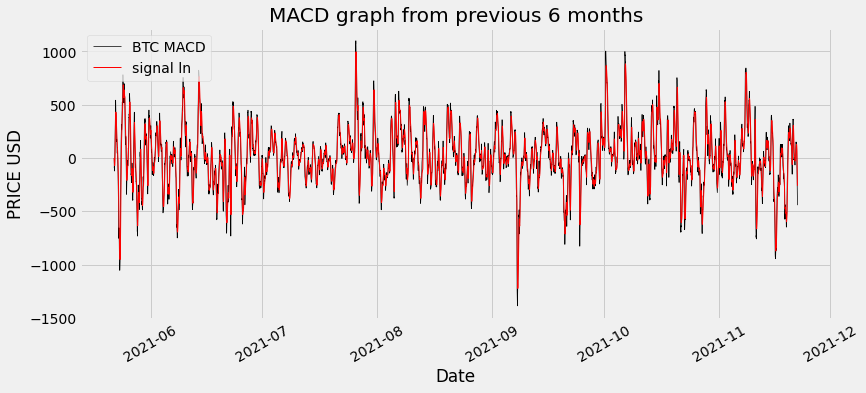

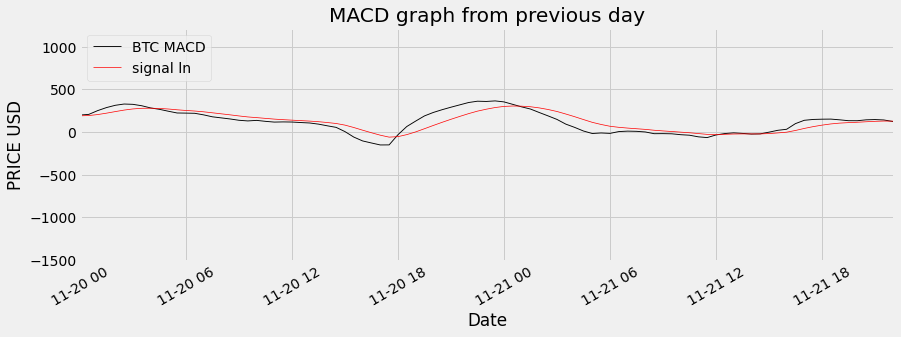

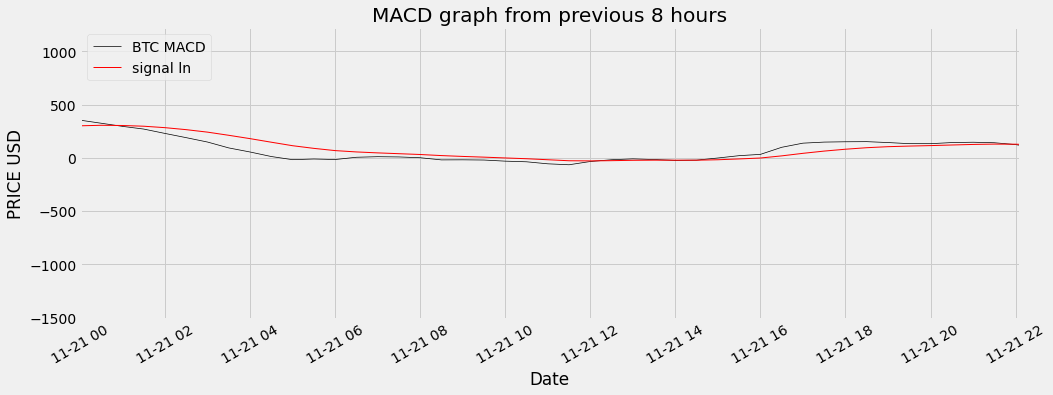

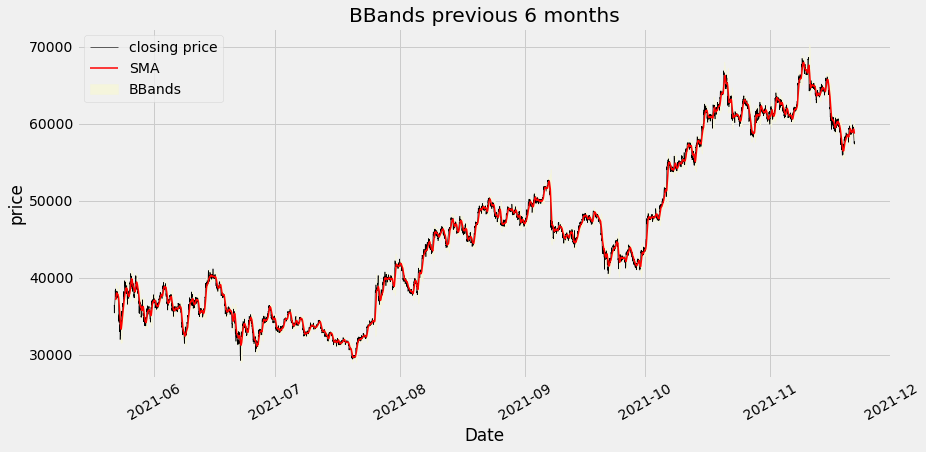

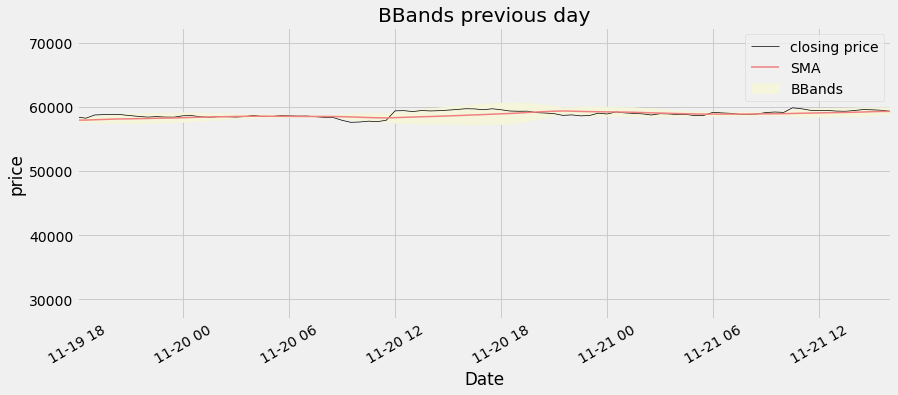

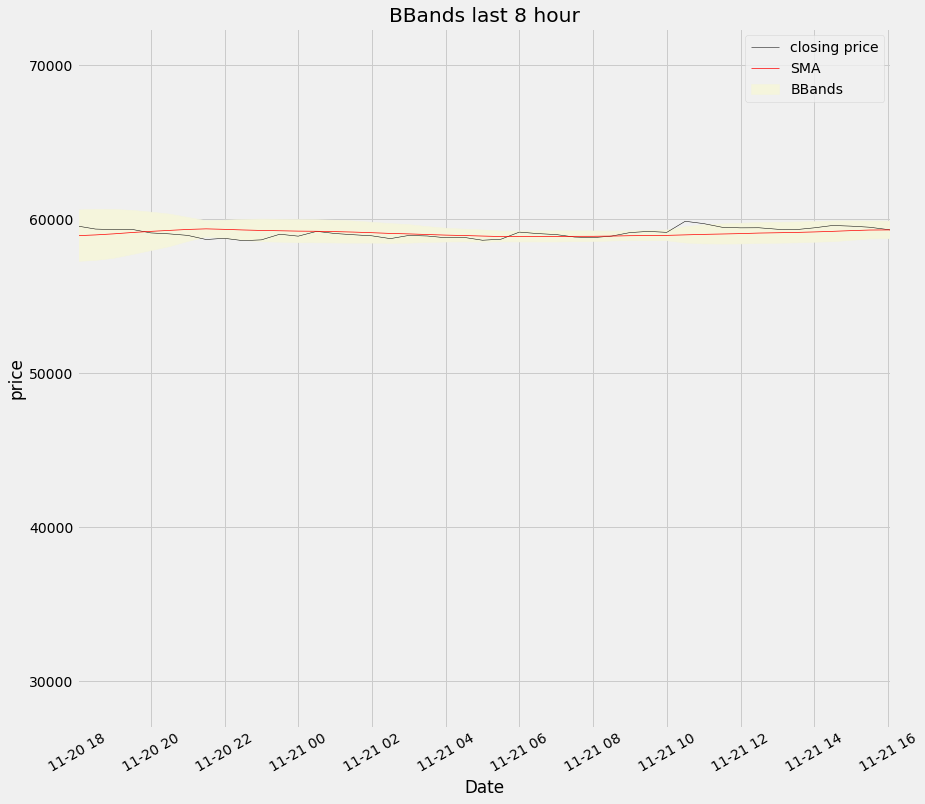

In [59]:
TI_graphs(crypto_df)

## BACKTESTING MACD

In [ ]:
# You cannot asume you will buy or sell exactly on the notification time, 
#but you can assume you will buy in the next time
Buy, Sell = [],[]
for i in range(2,len(crypto_MACD_df)):
    if crypto_MACD_df.MACD_line.iloc[i] > crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]< crypto_MACD_df.Sig_line.iloc[i-1]:
        Buy.append(i)
    elif crypto_MACD_df.MACD_line.iloc[i] < crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]> crypto_MACD_df.Sig_line.iloc[i-1]:
        Sell.append(i)

In [ ]:
realbuy = [i+1 for i in Buy]
realsell = [i+1 for i in Sell]
                                                                             

In [ ]:
buyprice = crypto_MACD_df.Open.iloc[realbuy]
buyprice


In [ ]:
sellprice =crypto_MACD_df.Open.iloc[realsell]
sellprice

In [ ]:
# to calculate profit, exclude initial and final buying or selling condition
if sellprice.index[0]<buyprice.index[0]:
    sellprice = sellprice.drop(sellprice.index[0])
elif buyprice.index[-1]>buyprice.index[-1]:
    buyprice = buyprice.drop(buyprice.index[-1])
    

In [ ]:
profitsrel = []
for i in range(len(sellprice)):
    profitsrel.append((sellprice[i]-buyprice[i])/buyprice[i])

In [ ]:
profits_df = pd.DataFrame(profitsrel)
profits_df.describe()
